### 500 simulations with static parameters, evaluating frequency of homozygous TSG disruption

In [26]:
library(naturalsort)
library(boot)
library(pracma)
library(viridis)
cols1 <- magma(520)

dataDir <- '~/jackgl/Data/simulations/0519/coread_0520_2/'
ctype <- 'GBM'

# Constant parameters for the simulations:
mu <- 0.1
sd <- 0.1
sp <- 0.005
N0 <- 1000

In [27]:
flst <- naturalsort(list.files(dataDir))
flst <- flst[2:(length(flst))]

#### Load population size time series

In [28]:
Ns <- array(NA,dim=c(length(flst),5e3))

for (ii in 1:length(flst)) {
load(paste0(dataDir,flst[ii]))
N[N==0] <- NA
Ns[ii,] <- N
}
dim(Ns)


[1]  500 5000

#### Calculate statistics over time

In [29]:
Ns_repmean <- apply(Ns,c(2),mean)
Ns_repmed <- apply(Ns,c(2),median)
Ns_repstd <- apply(Ns,c(2),std)

#### Get average number of heterozygous and homozygous driver and passenger mutations per cell

In [30]:
nd_het <- array(NA,dim=c(length(flst),1))
np_het <- array(NA,dim=c(length(flst),1))
nd_hom <- array(NA,dim=c(length(flst),1))
np_hom <- array(NA,dim=c(length(flst),1))

for (ii in 1:length(flst)) {
    load(paste0(dataDir,flst[ii]))
    nd_het[ii] <- sum(Pop$nd_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_het[ii] <- sum(Pop$np_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    nd_hom[ii] <- sum(Pop$nd_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_hom[ii] <- sum(Pop$np_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
}


#### Plot smoothed population size time series for all simulations

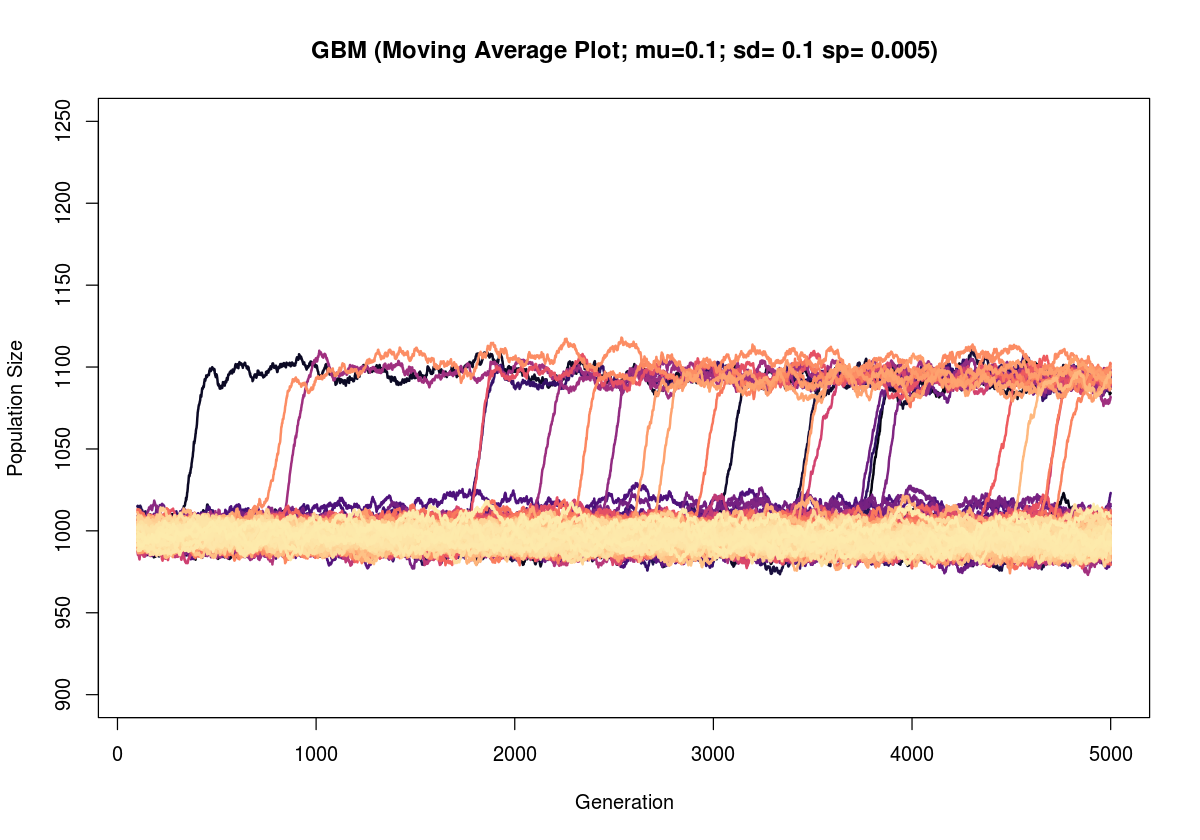

In [31]:
plot(100:length(Ns[1,]),tail(movavg(Ns[1,],100,'s'),4901),type='l',main=paste0(ctype,' (Moving Average Plot; mu=',toString(mu),';',' sd= ',toString(sd),' sp= ',toString(sp),')'),xlab='Generation',ylab='Population Size',col=cols1[1],lwd=2,ylim=c(900,1250))
for (i in 1:length(flst)) {lines(100:length(Ns[i,]),tail(movavg(Ns[i,],100,'s'),4901),type='l',col=cols1[i],lwd=2)}

#### Get population size fold changes

In [32]:
Ns_fc <- array(NA,dim=c(500,1))

for (ii in 1:length(flst)) {
    tmp <- movavg(Ns[ii,],100,'s')
    Ns_fc[ii] <- tmp[length(which(!is.na(tmp)))]/tmp[1]
}

rm(tmp)
Ns_fc_mean <- mean(Ns_fc)
Ns_fc_med <- median(Ns_fc)
Ns_fc_std <- std(Ns_fc)

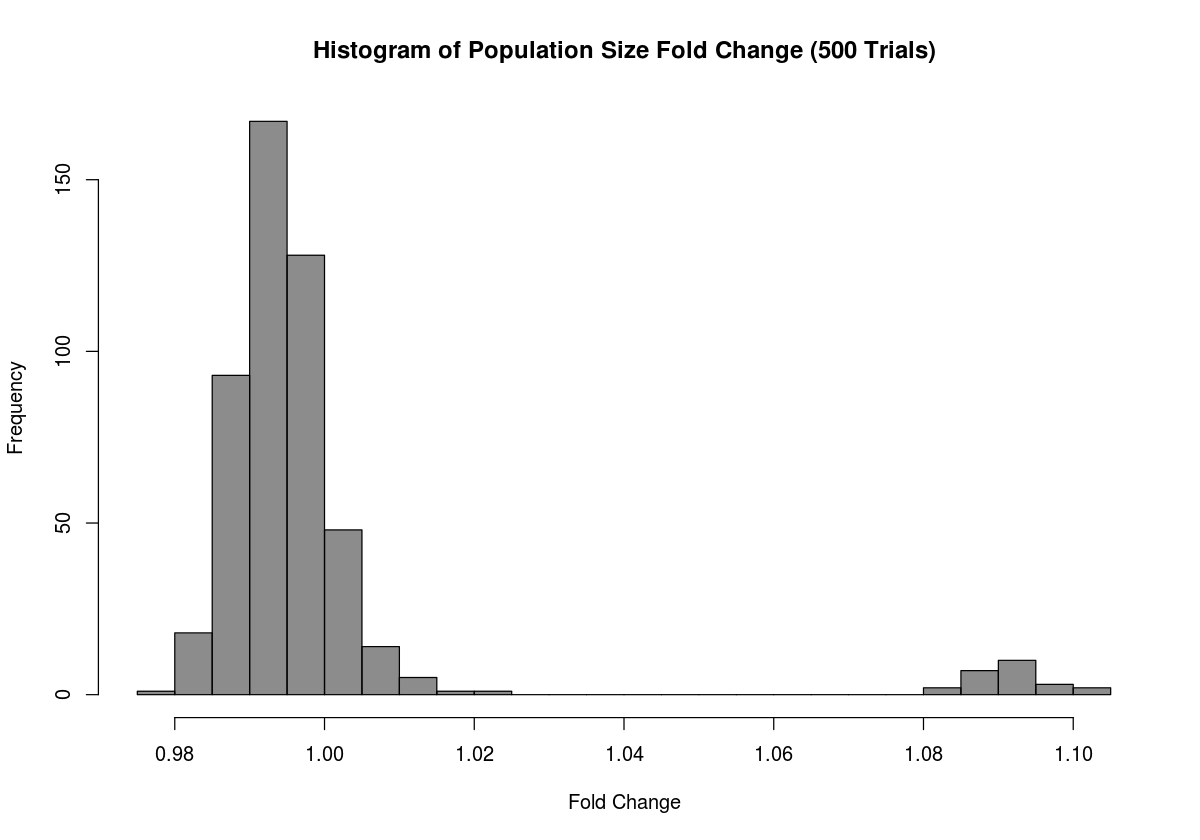

In [33]:
options(repr.plot.width=10, repr.plot.height=7)
hist(Ns_fc,20,main=paste0('Histogram of Population Size Fold Change (',toString(length(flst)),' Trials)'),xlab='Fold Change',col=rgb(0.1,0.1,0.1,0.5))

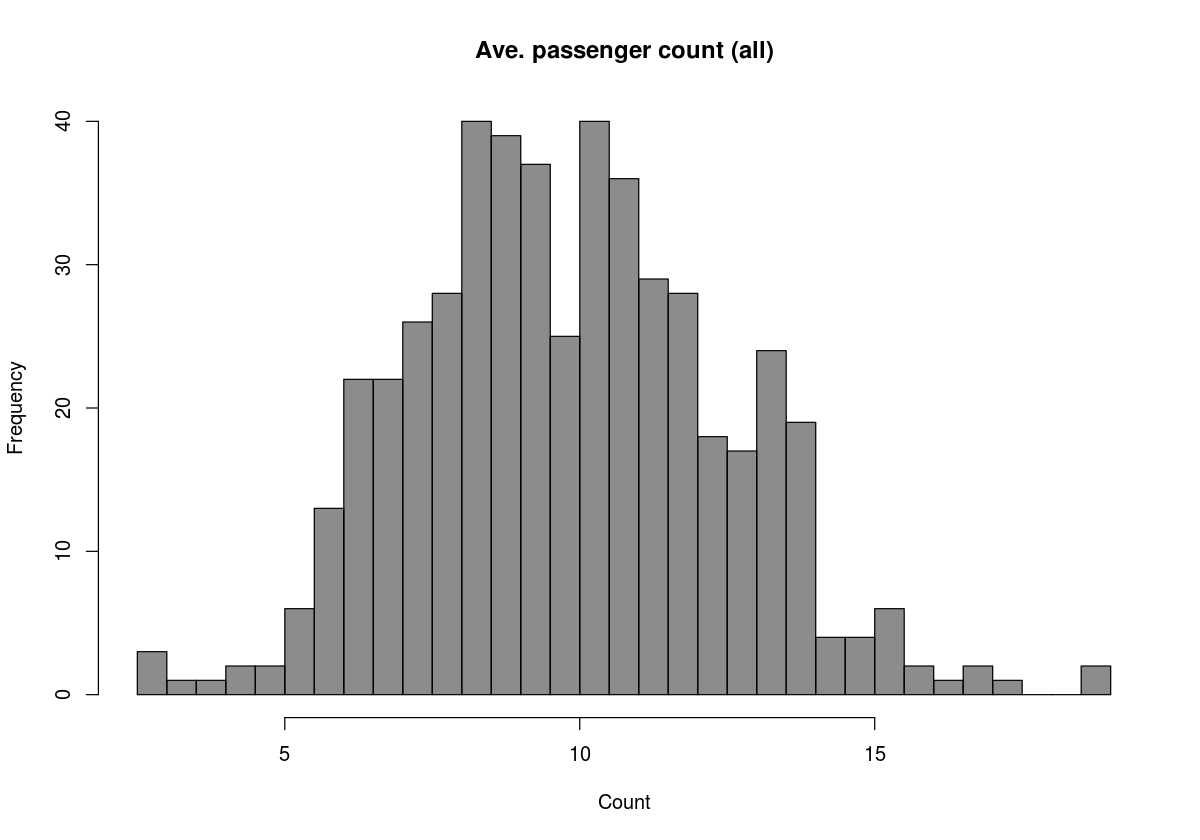

In [34]:
hist((np_het+(np_hom*2)),25,col=rgb(0.1,0.1,0.1,0.5),main='Ave. passenger count (all)',
     xlab='Count')

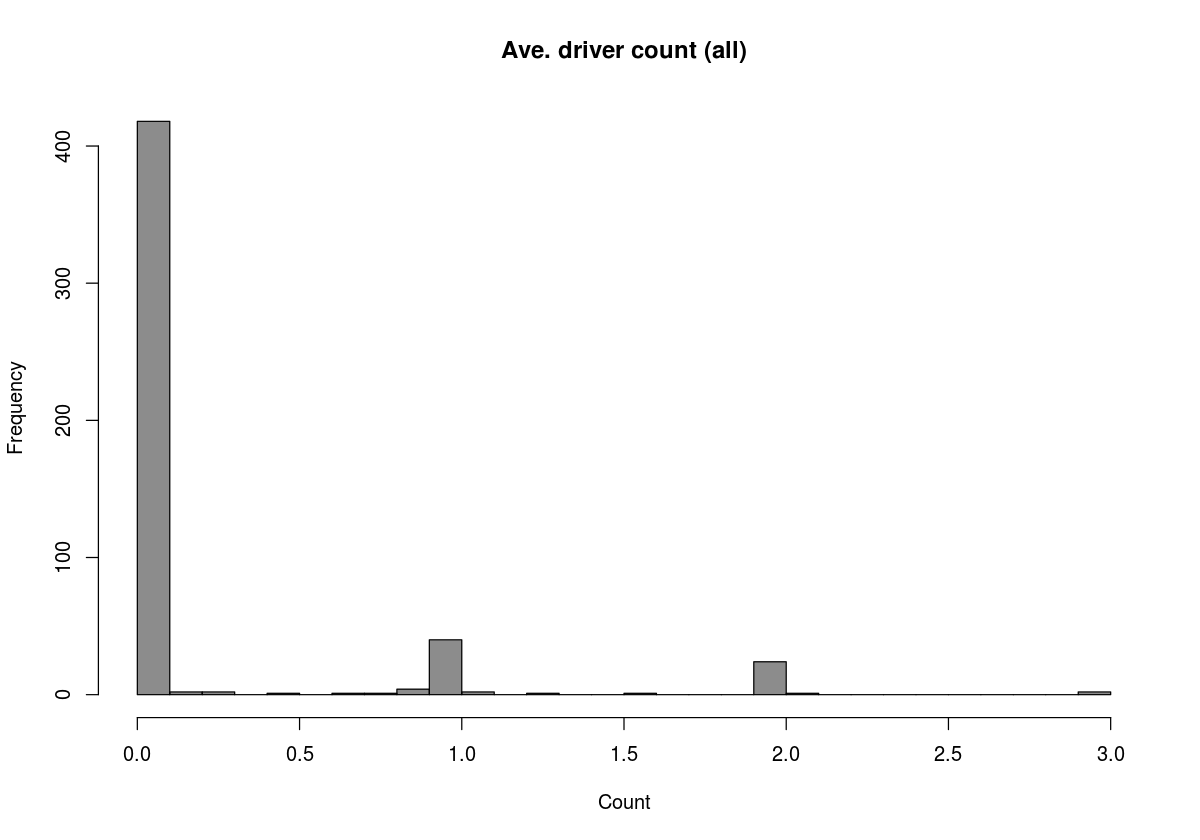

In [35]:
hist((nd_het+(nd_hom*2)),25,col=rgb(0.1,0.1,0.1,0.5),main='Ave. driver count (all)',
     xlab='Count')

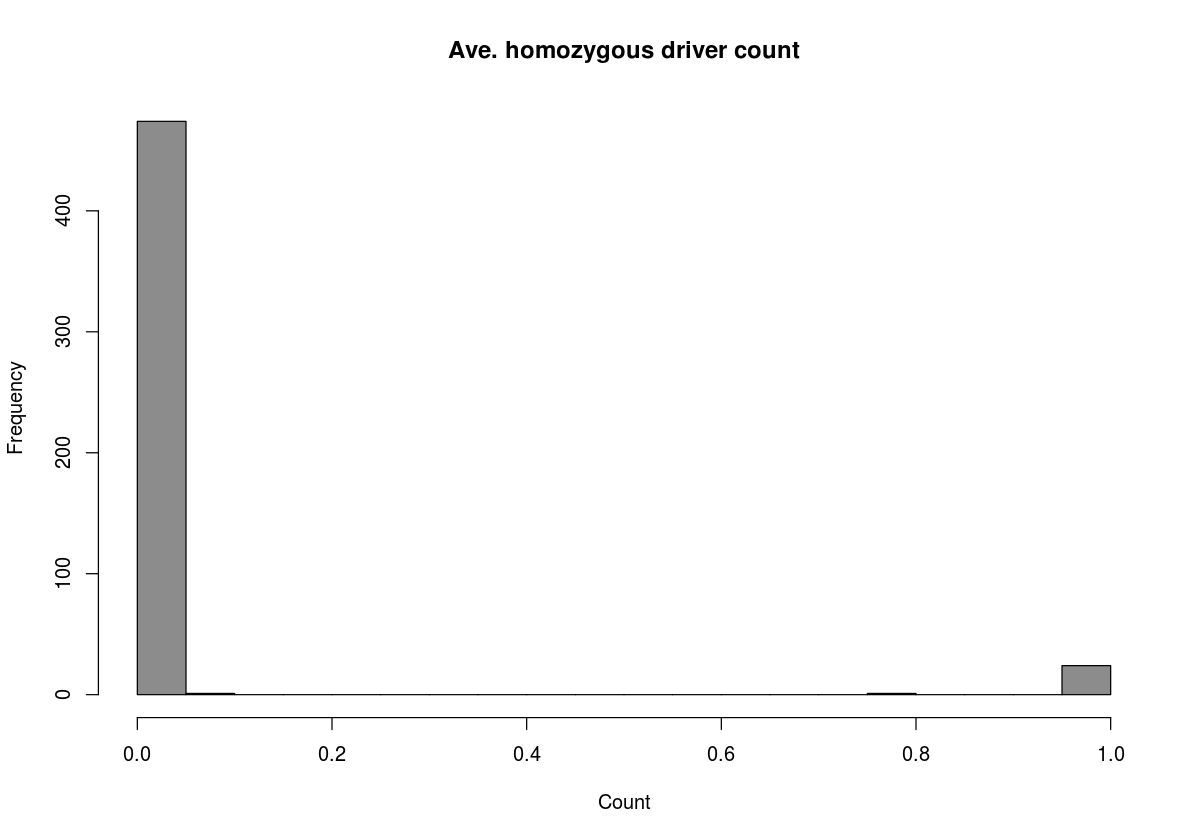

In [36]:
hist(nd_hom,25,col=rgb(0.1,0.1,0.1,0.5),main='Ave. homozygous driver count',
     xlab='Count')

#### Frequency of populations with at least one L1 heterzygous driver occurring

In [37]:
length(which((nd_het+(nd_hom*2))>=1))/length(flst)

[1] 0.138

#### Frequency of populations with at least one L1 homozygous driver occurring (average number of hom. drivers > 0.5)

In [38]:
length(which(nd_hom>=0.5))/length(flst)

[1] 0.05

#### Frequency of homozygous TP53 mutation (% cases in which 50% cells become homozygous)

In [39]:
tp53_log <- rep(0,length(flst))
for (i in 1:length(flst)) { # Loop over files
    load(paste0(dataDir,flst[i])) # Load file
    # Check for homozygous APC mutation in each clone
    tmp <- lapply(Pop[Pop$ncells>0,]$genes_hom, function(x) 'ENSG00000134982' %in% x)
    tmp2 <- Pop[Pop$ncells>0,]$ncells
    if (sum(as.numeric(tmp)*tmp2)/sum(tmp2) > 0.5) {
        tp53_log[i] <- 1
    }
}

In [40]:
length(which(tp53_log==1))/length(flst)

[1] 0

#### Get frequency for all TSGs

In [41]:
geneList <- as.vector(read.csv('~/jackgl/sim-develop/data/gene_lists/drivers_coread_filt.txt',header=F)$V1)
d_log <- array(0,c(length(geneList),length(flst)))
for (i in 1:length(flst)) {
    load(paste0(dataDir,flst[i]))
    for (j in 1:length(geneList)) {
        tmp <- lapply(Pop[Pop$ncells>0,]$genes_hom, function(x) geneList[j] %in% x)
        tmp2 <- Pop[Pop$ncells>0,]$ncells
        if (sum(as.numeric(tmp)*tmp2)/sum(tmp2) > 0.5) {
            d_log[j,i] <- 1
        }
    }
}

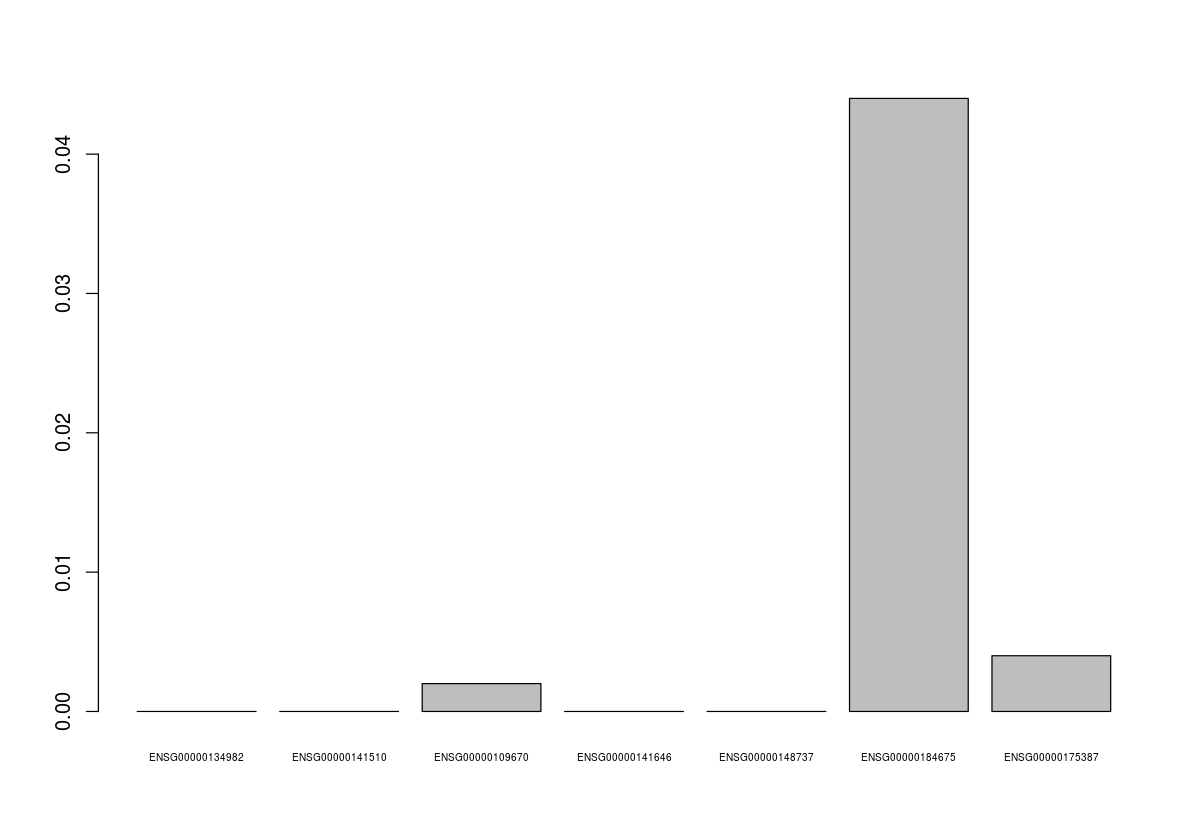

In [42]:
d_dist <- rep(0,length(geneList))
for (i in 1:length(geneList)) {
    d_dist[i] <- length(which(d_log[i,]==1))/length(flst)
}
                      
names(d_dist) <- geneList
barplot(d_dist,cex.names=0.5)

In [43]:
prop <- function(data,indices) {
    d <- data[indices]
    return(length(which(d>=0.5))/length(d))
}

tmp <- colSums(d_log) # For each run, sum the number of driver genes homozygous disrupted in >=50% of cells
tmp[tmp>1] = 1 # Create a logical vector for the case of at least 1

boottest <- boot(tmp,prop,1e4)

boot.ci(boottest, type='basic')

# print(boottest)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = boottest, type = "basic")

Intervals : 
Level      Basic         
95%   ( 0.030,  0.068 )  
Calculations and Intervals on Original Scale

In [44]:
boottest <- boot(d_log[1,],prop,1e4)

boot.ci(boottest, type='basic')

# print(boottest)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = boottest, type = "basic")

Intervals : 
Level      Basic         
95%   ( 0,  0 )  
Calculations and Intervals on Original Scale